# 期中報告

## 1. 引入套件

In [1]:
from datetime import datetime
from collections import Counter

import jieba
import jieba.analyse
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

In [2]:
# 設定圖的字體
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 機車版(biker)文章
+ 關鍵字:「電動機車、電動車、機車選購、充電、保養、優惠、服務、折扣」
+ 時間: 2020-01-01 ~ 2023-04-12
+ 資料筆數：共 1517 篇文章

In [3]:
#匯入資料
df = pd.read_csv('rawData/buyMotor_2017_2023.csv')
df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\n\n 欲比較車種時，請...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,2,https://www.ptt.cc/bbs/biker/M.1483383716.A.A3...,[討論]霧季到霧中行車該注意什麼?,2017-01-02 18:55:52,FECer,biker,這一兩天西部地區都有濃霧出現\n\n看到板上以前的文中有提到幾個在霧中行車該注意的\n\n放...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""blackhippo"",...",125.224.210.237,2018-04-29 07:05:28,ptt
2,3,https://www.ptt.cc/bbs/biker/M.1483416557.A.31...,[閒聊]白牌小車被逼車過的請進,2017-01-03 04:03:14,Haooconnor,biker,大家好，小弟我發這篇文不是來討拍，我想請問各位大大有沒有遇過惡劣的駕\n駛任意變換車道、急煞...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Davil0130"", ...",223.141.199.140,2018-04-29 07:05:28,ptt
3,4,https://www.ptt.cc/bbs/biker/M.1483420431.A.5C...,[問題]請問這台二手SYMGT該下手嗎,2017-01-03 05:07:46,J0825N,biker,最近朋友有台車想賣\n\n是2014年出廠的SYM GT125\n\n車況滿新的，平常都有在...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""blackyy"", ""c...",101.12.103.223,2018-04-29 07:05:28,ptt
4,5,https://www.ptt.cc/bbs/biker/M.1483461332.A.DD...,Fw:[合作]《PTT聯合*書寶》年終公益募集活動,2017-01-03 16:29:31,Derek324kimo,biker,作者: tencc2871 (莫) 看板: BB_Book2017\n標題: [合作] 《P...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""samhou6"", ""c...",123.194.128.204,2018-04-29 07:05:28,ptt
...,...,...,...,...,...,...,...,...,...,...,...
2727,2728,https://www.ptt.cc/bbs/biker/M.1680008773.A.01...,[問題]輕檔通勤耐久後胎選擇,2023-03-28 21:06:10,OOQ,biker,小弟前年入手二手KAWASAKI Z300\n當時原車主剛換全新倍耐力ROSSO SPORT...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""caca80207"", ...",36.235.201.215,2023-03-29 01:03:47,ptt
2728,2729,https://www.ptt.cc/bbs/biker/M.1680053137.A.3E...,[問題]二手fighter6跟全新迪爵,2023-03-29 09:25:34,wasley,biker,請問板上的大大\n最近想換車\n然後希望置物空間可以大一點\n目前的價格帶看到有\n二手的f...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""shingatter"",...",49.216.43.16,2023-03-30 01:03:54,ptt
2729,2730,https://www.ptt.cc/bbs/biker/M.1680099669.A.07...,[選購]jetsl/sr/勁戰六代,2023-03-29 22:21:07,relaxcloud,biker,《是否至車行看過實車》\n\nNo （算是吧？\n\n《欲比較之品牌及車種》\n\n(1)j...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""james725twtw...",36.226.25.23,2023-03-30 01:03:54,ptt
2730,2731,https://www.ptt.cc/bbs/biker/M.1680108698.A.B8...,[問題]二手該選雲豹200還是150?,2023-03-30 00:51:36,Raven29,biker,皆為2008年化油版(目前都還沒看到實車)\n\n《廠牌型號》 雲豹150 | 雲豹200\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a151091"", ""c...",116.241.162.145,2023-03-30 01:03:54,ptt


### 2.2 資料初步清理
清除內文為空值的文章<br>
透過觀察發現ptt的文章常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號，並清除不重要的字如換行、網址

In [4]:
clear_df = df.copy()

#去除有包含空值的筆數
clear_df.dropna(axis=0, how='any')

#用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace(r'\\n\\n', '。', regex=True).replace(r'\n', '', regex=True)

#移除內文中的網址
clear_df['artContent'] = clear_df['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。 欲比較車種時，請在標題打...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,2,https://www.ptt.cc/bbs/biker/M.1483383716.A.A3...,[討論]霧季到霧中行車該注意什麼?,2017-01-02 18:55:52,FECer,biker,這一兩天西部地區都有濃霧出現看到板上以前的文中有提到幾個在霧中行車該注意的放慢車速外(機車也...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""blackhippo"",...",125.224.210.237,2018-04-29 07:05:28,ptt
2,3,https://www.ptt.cc/bbs/biker/M.1483416557.A.31...,[閒聊]白牌小車被逼車過的請進,2017-01-03 04:03:14,Haooconnor,biker,大家好，小弟我發這篇文不是來討拍，我想請問各位大大有沒有遇過惡劣的駕駛任意變換車道、急煞的經...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Davil0130"", ...",223.141.199.140,2018-04-29 07:05:28,ptt
3,4,https://www.ptt.cc/bbs/biker/M.1483420431.A.5C...,[問題]請問這台二手SYMGT該下手嗎,2017-01-03 05:07:46,J0825N,biker,最近朋友有台車想賣是2014年出廠的SYM GT125車況滿新的，平常都有在保養不過是油化的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""blackyy"", ""c...",101.12.103.223,2018-04-29 07:05:28,ptt
4,5,https://www.ptt.cc/bbs/biker/M.1483461332.A.DD...,Fw:[合作]《PTT聯合*書寶》年終公益募集活動,2017-01-03 16:29:31,Derek324kimo,biker,作者: tencc2871 (莫) 看板: BB_Book2017標題: [合作] 《PTT...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""samhou6"", ""c...",123.194.128.204,2018-04-29 07:05:28,ptt
...,...,...,...,...,...,...,...,...,...,...,...
2727,2728,https://www.ptt.cc/bbs/biker/M.1680008773.A.01...,[問題]輕檔通勤耐久後胎選擇,2023-03-28 21:06:10,OOQ,biker,小弟前年入手二手KAWASAKI Z300當時原車主剛換全新倍耐力ROSSO SPORT可是...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""caca80207"", ...",36.235.201.215,2023-03-29 01:03:47,ptt
2728,2729,https://www.ptt.cc/bbs/biker/M.1680053137.A.3E...,[問題]二手fighter6跟全新迪爵,2023-03-29 09:25:34,wasley,biker,請問板上的大大最近想換車然後希望置物空間可以大一點目前的價格帶看到有二手的fighter6 ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""shingatter"",...",49.216.43.16,2023-03-30 01:03:54,ptt
2729,2730,https://www.ptt.cc/bbs/biker/M.1680099669.A.07...,[選購]jetsl/sr/勁戰六代,2023-03-29 22:21:07,relaxcloud,biker,《是否至車行看過實車》No （算是吧？《欲比較之品牌及車種》(1)jet sl(2)jet ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""james725twtw...",36.226.25.23,2023-03-30 01:03:54,ptt
2730,2731,https://www.ptt.cc/bbs/biker/M.1680108698.A.B8...,[問題]二手該選雲豹200還是150?,2023-03-30 00:51:36,Raven29,biker,皆為2008年化油版(目前都還沒看到實車)《廠牌型號》 雲豹150 | 雲豹200《里程》 ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a151091"", ""c...",116.241.162.145,2023-03-30 01:03:54,ptt


### 2.3 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [5]:
clear_df['artContent'] = clear_df['artContent'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('artContent').reset_index(drop=True)

# 把長度小於1的content刪掉
sent_df = sent_df[sent_df["artContent"].str.len() > 1]

sent_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,請自行刪除所有內容,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
2,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,欲比較車種時,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
3,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,請在標題打上車種名稱,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
4,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"如：GSR/新勁戰/RS 請勿使用""請問新車""、""請推薦車""等過於模糊不方便搜尋的標題 ...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
...,...,...,...,...,...,...,...,...,...,...,...
41957,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,若lx fl改為相同形式,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
41958,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,是否行車質感及運動性也與pmv車系相去不遠,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
41959,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,3.3vie iget 差異請問這兩款除了新舊及動力上的差異,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,在耐久度跟運轉品質上是否有差,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt


### 2.4 斷詞
斷詞引擎設定：使用 Jieba 當作斷詞系統。
Jieba原先內建為簡體字字典，但我們可以使用繁體字典來做為替換，結果會比較好。另外可能還有一些專有名詞是沒有被包含在預設字典當中，我們也可以使用自定義字典的方式加入，或者使用參數的形式帶入。

In [6]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
# 將user_dict改為以下字詞陳吉仲、好市多、好事多、產蛋率、吉仲
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\dict\dict.txt ...
Loading model from cache C:\Users\collin\AppData\Local\Temp\jieba.u5ae51a7e740c9af1ab5a92f566d53c76.cache
Loading model cost 0.382 seconds.
Prefix dict has been built successfully.


斷詞前先將標點符號清除，並清除空字串

In [7]:
sent_df['artContent'] = sent_df['artContent'].str.replace(r'[^\w\s\d]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["artContent"].str.len() > 1]

sent_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,若僅為新車問題或心得文章者則不需此範本,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,請自行刪除所有內容,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
2,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,欲比較車種時,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
3,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,請在標題打上車種名稱,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
4,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,如GSR新勁戰RS 請勿使用請問新車請推薦車等過於模糊不方便搜尋的標題 請自行刪除以上補充,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
...,...,...,...,...,...,...,...,...,...,...,...
41957,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,若lx fl改為相同形式,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
41958,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,是否行車質感及運動性也與pmv車系相去不遠,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
41959,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,33vie iget 差異請問這兩款除了新舊及動力上的差異,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,在耐久度跟運轉品質上是否有差,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt


使用jieba進行斷詞

In [8]:
word_df = sent_df.assign(word = sent_df['artContent'].apply(jieba.lcut)).explode('word').drop(['artContent'], axis=1)

word_df = word_df.loc[word_df['word'].str.len()>1]

word_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,問題
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,心得
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,文章
...,...,...,...,...,...,...,...,...,...,...,...
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,品質
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,是否
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,有差
41961,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,感謝


### 2.5 移除停用字

In [9]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
# 新增目前、連結、標題、知道、報導、指出....等停用字
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

移除dataframe中的停用字

In [10]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,問題
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,心得
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,文章
...,...,...,...,...,...,...,...,...,...,...,...
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,耐久度
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,運轉
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,品質
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,有差


### 2.6 計算詞頻

In [11]:
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

,word,freq
0,機車,1728
1,問題,1550
2,車行,1402
3,目前,1250
4,知道,968
...,...,...
37530,地把車,1
37531,地感,1
37532,地想,1
37533,地心引力,1


### 2.7 視覺化結果

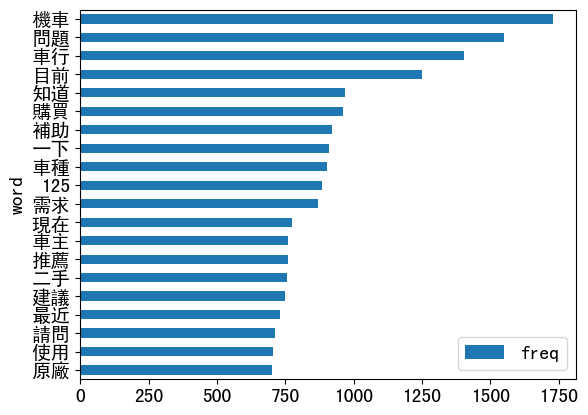

In [12]:
freq_df.iloc[:20].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

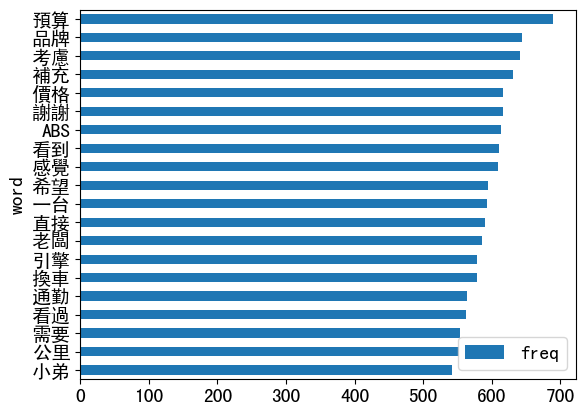

In [13]:
freq_df.iloc[20:40].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

### 2.8 更新停用字字典

In [14]:
# 參數形式手動加入停用字
stopwords_manual = ["謝謝", "一下", "問題", "感覺", "目前", "請問", "發現", "直接", "知道", "看到", "現在", "車子", "建議", "車主", "希望", "10", "一點", "機車", "最近", "老闆", "時間", "車行", "購買", "一台", "Yes", "小弟", "XD", "左右", "之後", "這台", "有沒有", "這種"]
stopwords.extend(stopwords_manual)

In [15]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,心得
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,文章
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,者則
...,...,...,...,...,...,...,...,...,...,...,...
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,耐久度
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,運轉
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,品質
41960,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,有差


#### 重新計算詞頻

In [16]:
freq_df_2 = pd.DataFrame({'freq':noStop_df_2.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']  
freq_df_2 = freq_df_2[clist]
freq_df_2

,word,freq
0,補助,922
1,車種,903
2,125,886
3,需求,869
4,推薦,759
...,...,...
37498,懸浮,1
37499,懷著,1
37500,懷舊,1
37501,懷抱,1


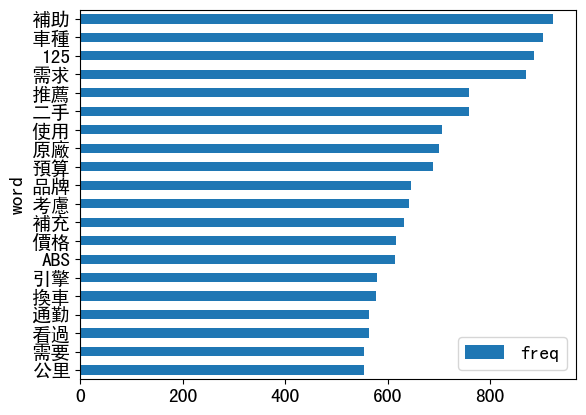

In [17]:
freq_df_2.iloc[:20].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

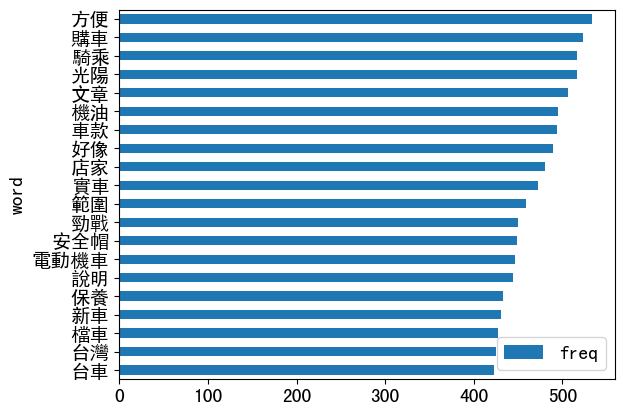

In [18]:
freq_df_2.iloc[20: 40].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

### 2.9 繪製文字雲

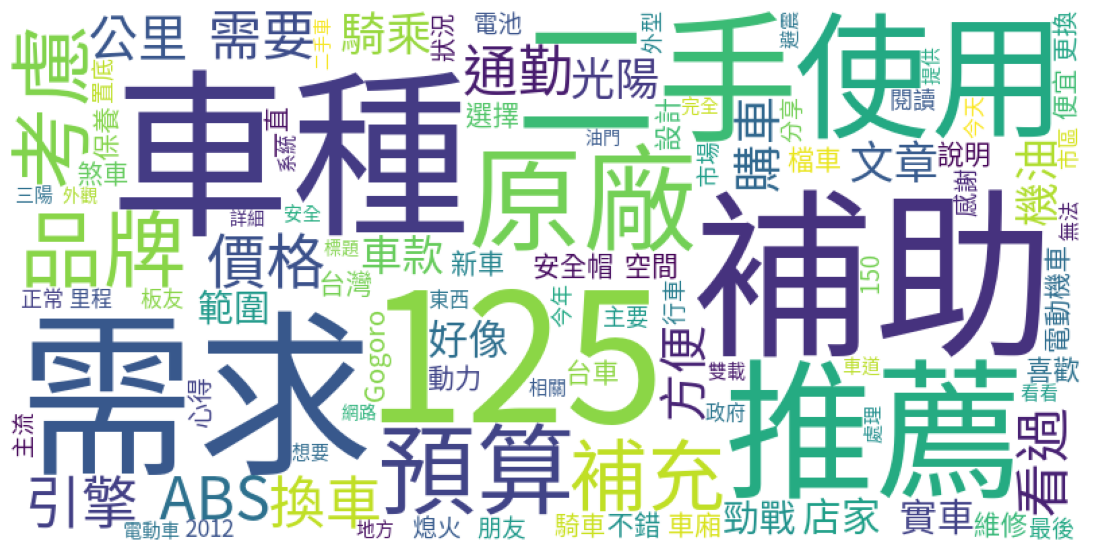

In [19]:
# 詞頻變成dict
freq_dict = freq_df_2.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']

# 繪製文字雲
FontPath = 'rawData/SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=FontPath, max_words=100)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
# plt.show()

# 儲存並顯示文字雲
plt.savefig('pic/wordcloud.png', bbox_inches='tight')

## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  

In [20]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [21]:
ptt_df = noStop_df_2.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [22]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                           249635
mean     2020-02-06 07:33:58.526685184
min                2017-01-02 14:38:41
25%                2018-08-13 16:41:39
50%                2020-03-11 00:17:52
75%                2021-06-06 16:29:35
max                2023-03-30 07:28:02
Name: artDate, dtype: object

In [23]:
ptt_df["artDate"] = ptt_df["artDate"].dt.date

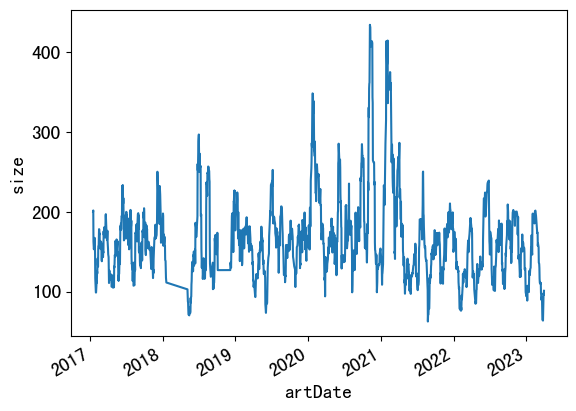

In [24]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。。

In [25]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artUrl,word,sentiments
0,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,若僅,NaN
1,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,新車,NaN
2,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,心得,NaN
3,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,文章,NaN
4,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,者則,NaN
...,...,...,...,...
262679,2023-03-30,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,運轉,NaN
262680,2023-03-30,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,品質,NaN
262681,2023-03-30,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,有差,NaN
262682,2023-03-30,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,感謝,affect


### 3.3 正負向情緒分數聲量折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [26]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
0,2017-01-02,affect,8
1,2017-01-02,negative,2
2,2017-01-02,positive,5
3,2017-01-02,NaN,176
4,2017-01-03,affect,39
...,...,...,...
6236,2023-03-29,sad,2
6237,2023-03-29,NaN,108
6239,2023-03-30,positive,1
6238,2023-03-30,affect,2


In [27]:
sentiment_count["sentiments"] == "positive"

0       False
1       False
2        True
3       False
4       False
        ...  
6236    False
6237    False
6239     True
6238    False
6240    False
Name: sentiments, Length: 6241, dtype: bool

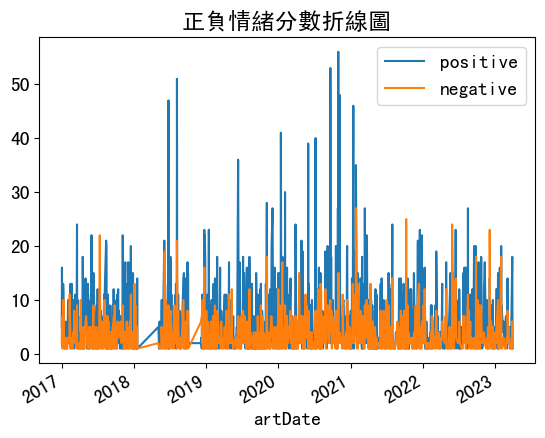

In [28]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖")  # 記得加上才能顯示中文
plt.show()

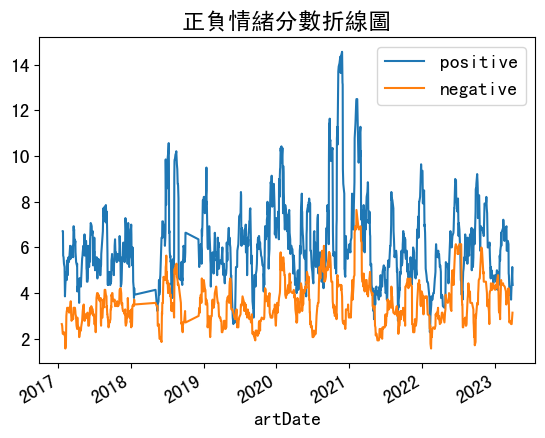

In [29]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天移動平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖")  # 記得加上才能顯示中文
plt.show()

### 3.4 正負向情緒分數比例折線圖

In [30]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
0,2017-01-02,affect,8,0.041885
1,2017-01-02,negative,2,0.010471
2,2017-01-02,positive,5,0.026178
3,2017-01-02,NaN,176,0.921466
4,2017-01-03,affect,39,0.066781
...,...,...,...,...
6236,2023-03-29,sad,2,0.015385
6237,2023-03-29,NaN,108,0.830769
6239,2023-03-30,positive,1,0.007463
6238,2023-03-30,affect,2,0.014925


In [31]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

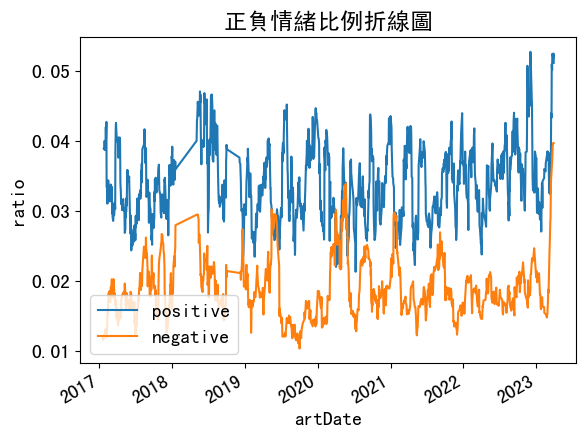

In [32]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.5 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [33]:
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
3902,2020-10-30,positive,56,0.034934
3752,2020-09-20,positive,53,0.054752
1577,2018-08-07,positive,51,0.041497
3933,2020-11-06,positive,48,0.041166
1417,2018-06-25,positive,47,0.046953


#### 2020-10-30 文字雲

In [34]:
date = "2020-10-30"
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

C:\Users\collin\AppData\Local\Temp\ipykernel_17816\4125349688.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))


[('BWS', 33),
 ('125', 23),
 ('車款', 18),
 ('設計', 17),
 ('全新', 13),
 ('空間', 13),
 ('Dedition', 11),
 ('Yamaha', 10),
 ('原廠', 9),
 ('確實', 9),
 ('設定', 9),
 ('騎乘', 9),
 ('懸吊', 8),
 ('越野', 8),
 ('感受', 7),
 ('表現', 7),
 ('車體', 7),
 ('出色', 6),
 ('動力', 6),
 ('帶來', 6)]

(-0.5, 799.5, 399.5, -0.5)

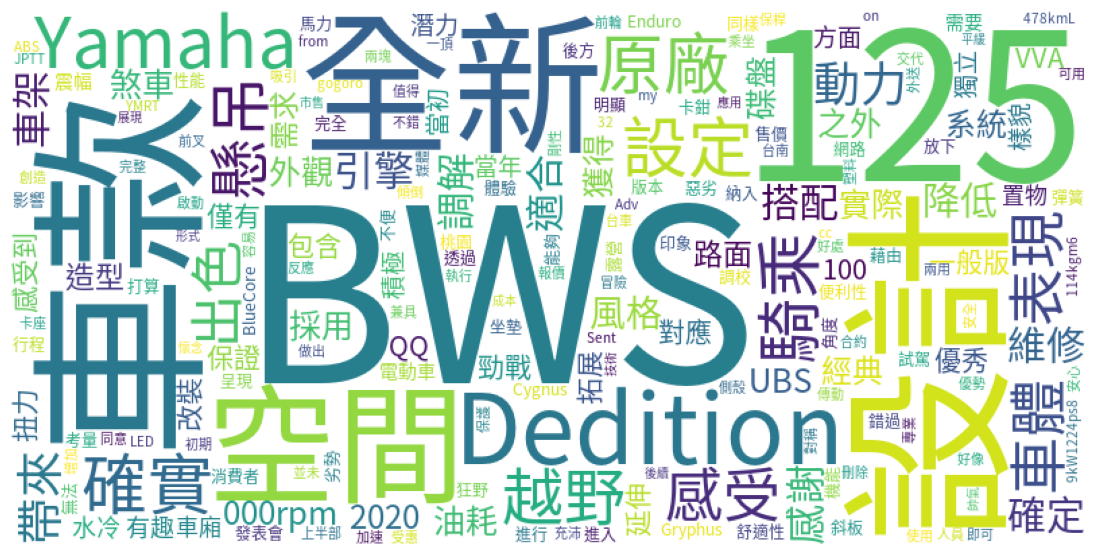

In [35]:
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

2020-10-30 是正面詞彙次數最高的一天。我們可以用文字雲來觀察，機車版在這天最常出現的正面情緒字有哪些。

C:\Users\collin\AppData\Local\Temp\ipykernel_17816\1533068079.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 799.5, 399.5, -0.5)

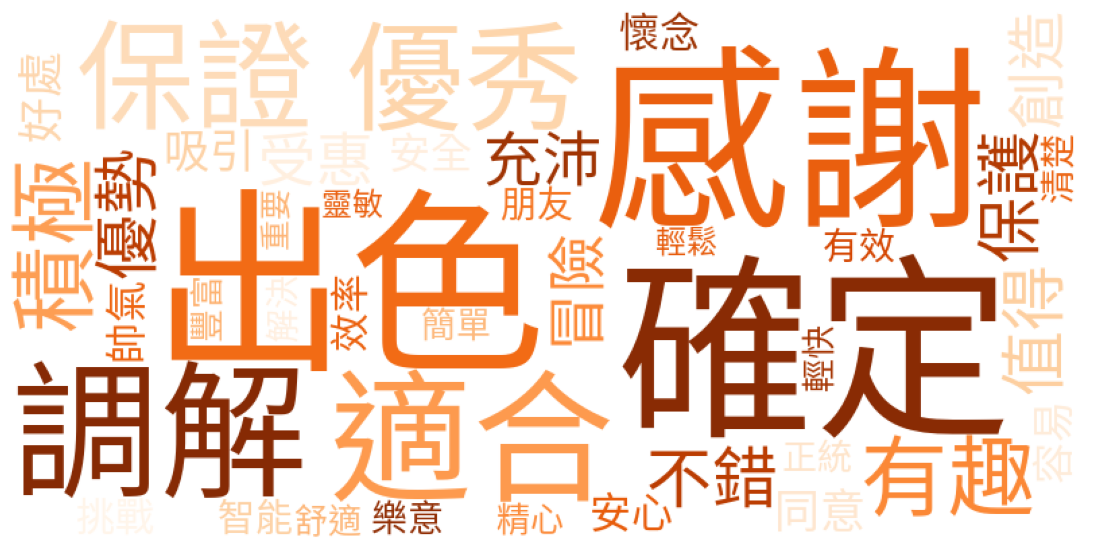

In [36]:
date = "2020-10-30"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

C:\Users\collin\AppData\Local\Temp\ipykernel_17816\1540206301.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 799.5, 399.5, -0.5)

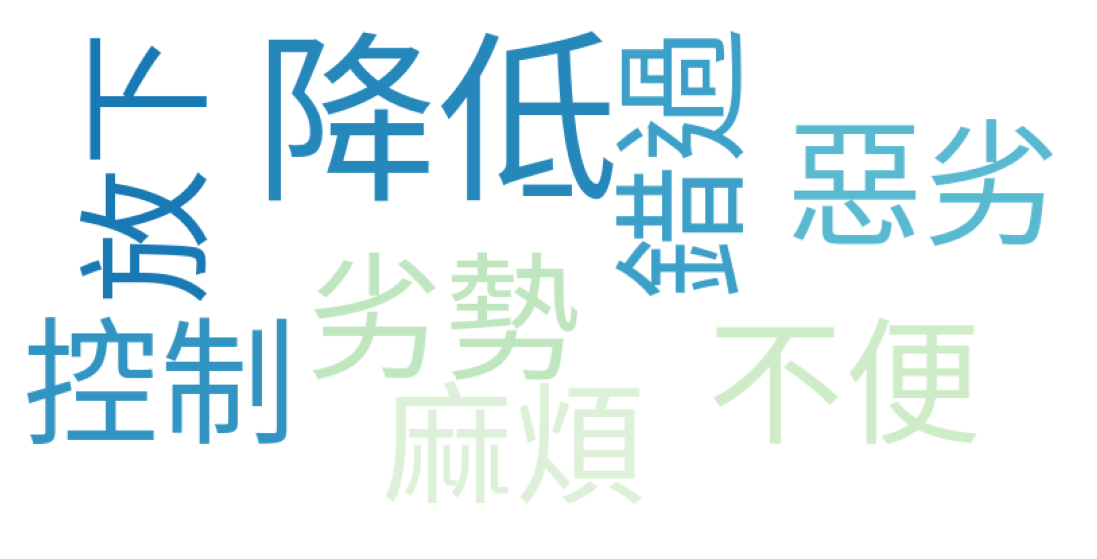

In [37]:
date = "2020-10-30"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [38]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
394,喜歡,positive,397
393,喜歡,affect,397
62,不錯,affect,373
63,不錯,positive,373
1026,朋友,positive,343
...,...,...,...
483,好事,affect,1
686,怒罵,negative,1
1420,糟蹋,affect,1
1421,糟蹋,anger,1


In [39]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos

,word,sentiments,size
394,喜歡,positive,397
63,不錯,positive,373
1026,朋友,positive,343
759,感謝,positive,337
234,分享,positive,314
...,...,...,...
1428,結實,positive,1
1430,絕妙,positive,1
208,光榮,positive,1
688,性感,positive,1


In [40]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg

,word,sentiments,size
1818,麻煩,negative,216
1456,缺點,negative,170
932,擔心,negative,114
1692,違規,negative,108
407,嚴重,negative,108
...,...,...,...
1034,枉然,negative,1
1056,欺詐,negative,1
496,妄想,negative,1
1422,糟蹋,negative,1


In [41]:
word_of_neg.sort_values(
    ["size"], ascending=False
)

,word,sentiments,size
1818,麻煩,negative,216
1456,缺點,negative,170
932,擔心,negative,114
1692,違規,negative,108
407,嚴重,negative,108
...,...,...,...
871,指責,negative,1
895,控訴,negative,1
344,可笑,negative,1
352,同情,negative,1


C:\Users\collin\AppData\Local\Temp\ipykernel_17816\1433489422.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\collin\AppData\Local\Temp\ipykernel_17816\1433489422.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

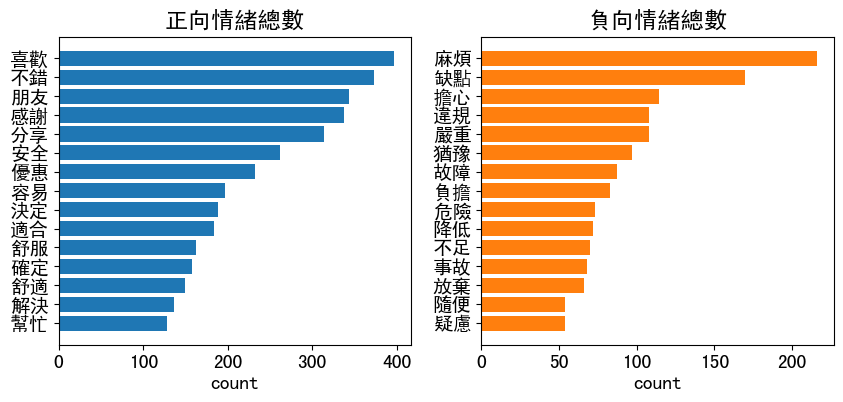

In [42]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

#### 2021-01-27 正負情緒代表字 - negative

In [43]:
sentiment_count[sentiment_count["sentiments"] == "negative"].sort_values('size', ascending=False)

,artDate,sentiments,size,ratio
4156,2021-01-27,negative,27,0.017952
4873,2021-10-08,negative,25,0.048638
5464,2022-05-28,negative,24,0.038400
5976,2022-12-04,negative,23,0.045010
620,2017-07-13,negative,22,0.031838
...,...,...,...,...
1915,2019-02-02,negative,1,0.010204
4545,2021-06-17,negative,1,0.019231
1919,2019-02-03,negative,1,0.023810
1947,2019-02-11,negative,1,0.015152


In [44]:
date = '2021-01-27'
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

C:\Users\collin\AppData\Local\Temp\ipykernel_17816\421090581.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (


,sentiments,word,size
0,negative,危險,1
1,negative,壓抑,1
2,negative,惡性,1
3,negative,惡意,1
4,negative,控制,2


C:\Users\collin\AppData\Local\Temp\ipykernel_17816\1670547556.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\collin\AppData\Local\Temp\ipykernel_17816\1670547556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


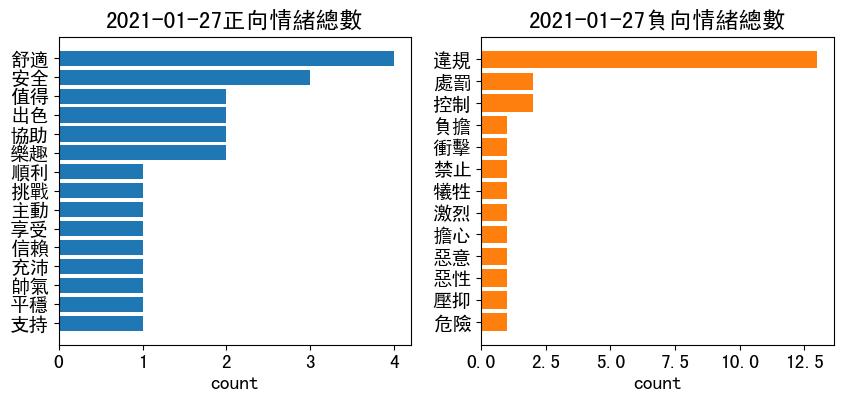

In [45]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{date}正向情緒總數")
ax[0].set_yticklabels(pos["word"])

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{date}負向情緒總數")
ax[1].set_yticklabels(neg["word"])
plt.show()

#### 2020-10-30 正負情緒代表字 - positive

In [46]:
sentiment_count[sentiment_count["sentiments"] == "positive"].sort_values('size', ascending=False)

,artDate,sentiments,size,ratio
3902,2020-10-30,positive,56,0.034934
3752,2020-09-20,positive,53,0.054752
1577,2018-08-07,positive,51,0.041497
3933,2020-11-06,positive,48,0.041166
1417,2018-06-25,positive,47,0.046953
...,...,...,...,...
1266,2018-01-19,positive,1,0.062500
4476,2021-05-17,positive,1,0.012048
1277,2018-05-08,positive,1,0.052632
4454,2021-05-10,positive,1,0.011364


In [47]:
date = '2020-10-30'
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

C:\Users\collin\AppData\Local\Temp\ipykernel_17816\3398094619.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (


,sentiments,word,size
0,negative,不便,1
1,negative,劣勢,1
2,negative,惡劣,1
3,negative,控制,1
4,negative,放下,1


C:\Users\collin\AppData\Local\Temp\ipykernel_17816\1670547556.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\collin\AppData\Local\Temp\ipykernel_17816\1670547556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


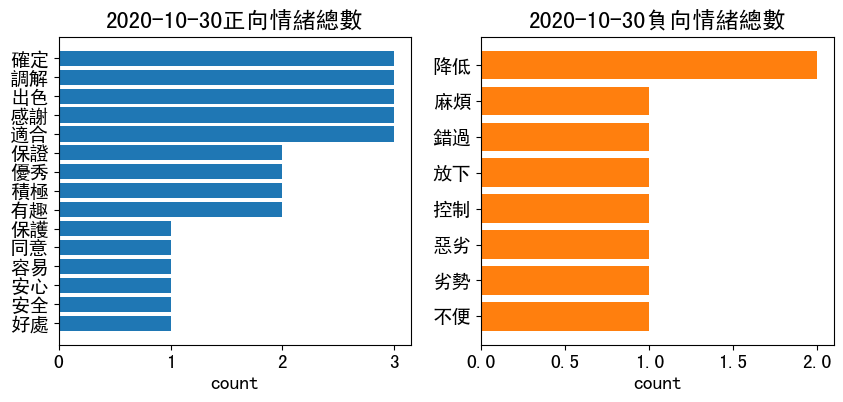

In [48]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{date}正向情緒總數")
ax[0].set_yticklabels(pos["word"])

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{date}負向情緒總數")
ax[1].set_yticklabels(neg["word"])
plt.show()

### 3.7 每日情緒分數趨勢

In [49]:
sentiment_count

,artDate,sentiments,size,ratio
0,2017-01-02,affect,8,0.041885
1,2017-01-02,negative,2,0.010471
2,2017-01-02,positive,5,0.026178
3,2017-01-02,NaN,176,0.921466
4,2017-01-03,affect,39,0.066781
...,...,...,...,...
6236,2023-03-29,sad,2,0.015385
6237,2023-03-29,NaN,108,0.830769
6239,2023-03-30,positive,1,0.007463
6238,2023-03-30,affect,2,0.014925


In [50]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad
0,2017-01-02,8,0,0,2,5,0
1,2017-01-03,39,2,3,7,16,1
2,2017-01-04,9,0,0,2,6,0
3,2017-01-05,1,0,0,1,0,1
4,2017-01-06,1,0,1,1,0,0


In [51]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad,sentiment_value
0,2017-01-02,8,0,0,2,5,0,3
1,2017-01-03,39,2,3,7,16,1,3
2,2017-01-04,9,0,0,2,6,0,4
3,2017-01-05,1,0,0,1,0,1,-2
4,2017-01-06,1,0,1,1,0,0,-2


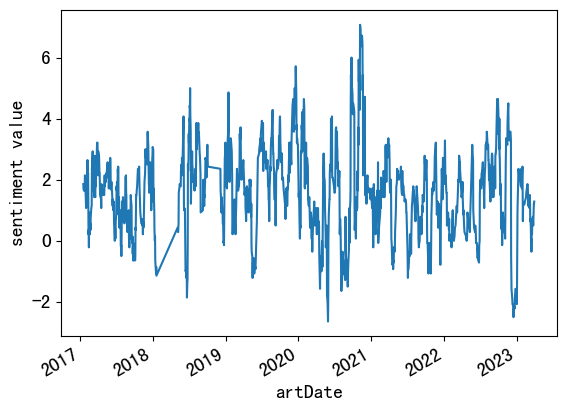

In [52]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

## 4. lexicon-base 情緒分析2

引入所需套件

In [53]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

### 4.1 CKIP 安裝

In [54]:
#data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

In [55]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell =

定義文字清理相關function

In [56]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), str(article).split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [57]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(4, {'電動機車': 100.0})]


In [58]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [59]:
# 看看tmp和flat_list有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['若僅為新車問題或心得文章者則不需此範本，請自行刪除所有內容'], ['欲比較車種時，請在標題打上車種名稱', '如/新勁戰/'], ['請勿使用"請問新車""請推薦車"等過於模糊不方便搜尋的標題'], ['請自行刪除以上補充'], []]
['若僅為新車問題或心得文章者則不需此範本，請自行刪除所有內容', '欲比較車種時，請在標題打上車種名稱', '如/新勁戰/', '請勿使用"請問新車""請推薦車"等過於模糊不方便搜尋的標題', '請自行刪除以上補充']


In [60]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

KeyboardInterrupt: 

In [ ]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,若,Cbb
1,1,僅,Da
2,1,為,VG
3,1,新,VH
4,1,車,Na


In [ ]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,雲豹,PERSON
1,1,四,CARDINAL
2,1,雲豹,PERSON
3,1,台中,GPE
4,2,這兩天,DATE


In [ ]:
sentence_table.head()

,system_id,sentence
0,1,若僅為新車問題或心得文章者則不需此範本，請自行刪除所有內容
1,1,欲比較車種時，請在標題打上車種名稱
2,1,如/新勁戰/
3,1,"請勿使用""請問新車""""請推薦車""等過於模糊不方便搜尋的標題"
4,1,請自行刪除以上補充


In [ ]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1517篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1349篇有抓到ner

total posts numbers: 2731
posts have NER: 2424


In [ ]:
# 將文章存成csv
pos_table.to_csv('rawData/pos_table_motor.csv', index = False)
entity_table.to_csv('rawData/entity_table_motor.csv', index = False)
sentence_table.to_csv('rawData/sentence_table_motor.csv', index = False)

### 4.2 探索分析 - NER

將剛才分析的資料匯入

In [ ]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("rawData/pos_table_motor.csv") 
entity_table = pd.read_csv("rawData/entity_table_motor.csv") 
sentence_table = pd.read_csv("rawData/sentence_table_motor.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [ ]:
entity_table['ner'].unique()

array(['PERSON', 'CARDINAL', 'GPE', 'DATE', 'ORG', 'TIME', 'FAC', 'LOC',
       'QUANTITY', 'PERCENT', 'MONEY', 'NORP', 'ORDINAL', 'PRODUCT',
       'WORK_OF_ART', 'EVENT', 'LANGUAGE', 'LAW'], dtype=object)

In [ ]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
1,DATE,3827
0,CARDINAL,3750
4,GPE,2316
11,ORG,1893
13,PERSON,1755
10,ORDINAL,622
16,TIME,592
8,MONEY,452


C:\Users\collin\AppData\Local\Temp\ipykernel_3032\3390866936.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


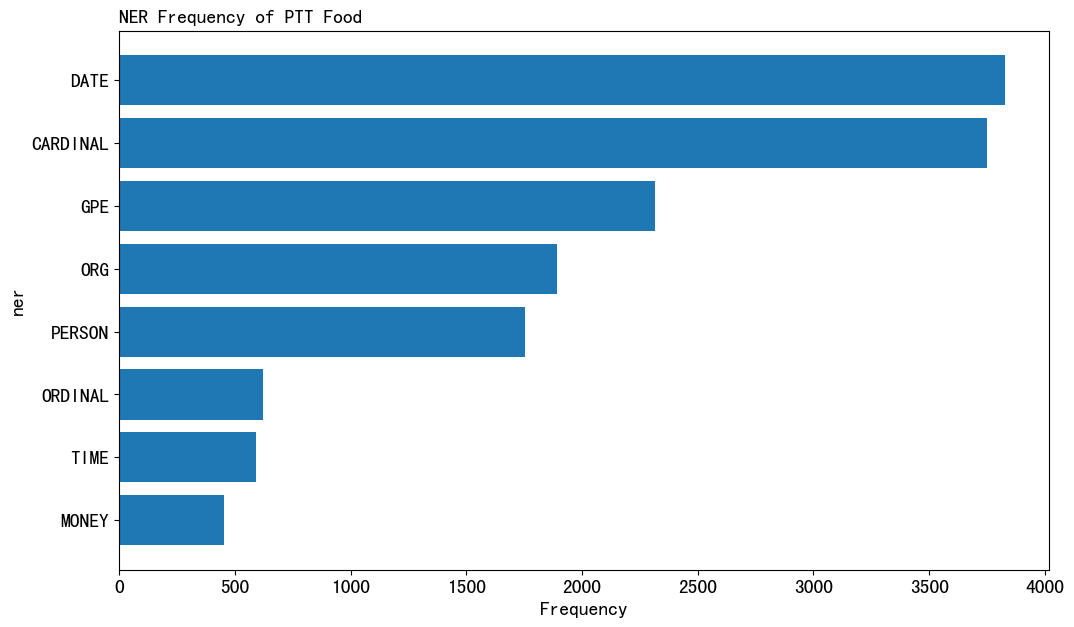

In [ ]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的人名(PERSON)

C:\Users\collin\AppData\Local\Temp\ipykernel_3032\2044175467.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


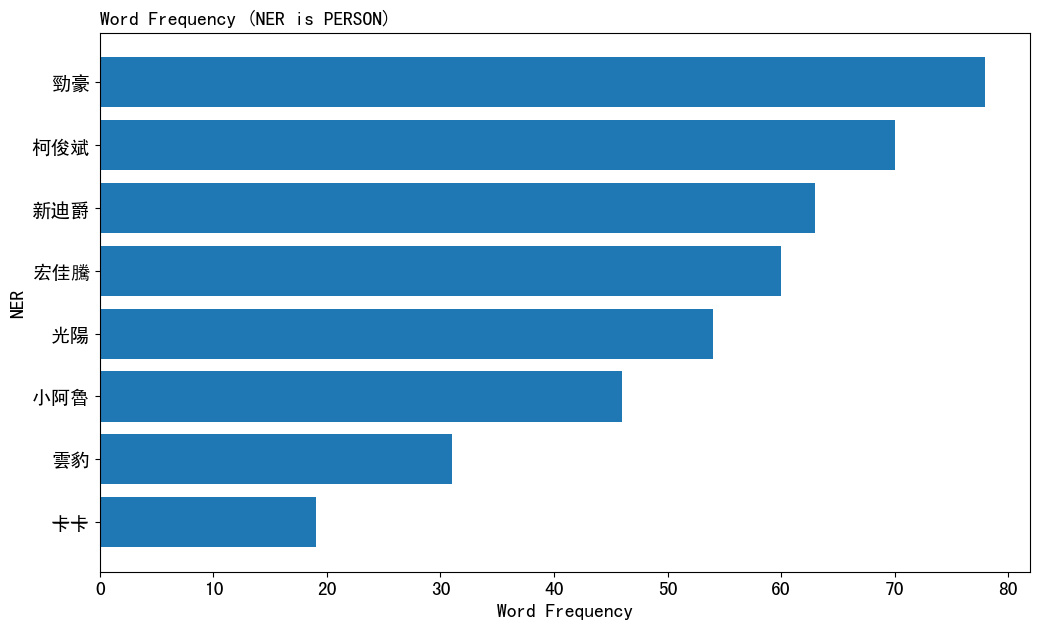

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的組織(ORG)

C:\Users\collin\AppData\Local\Temp\ipykernel_3032\3690618897.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


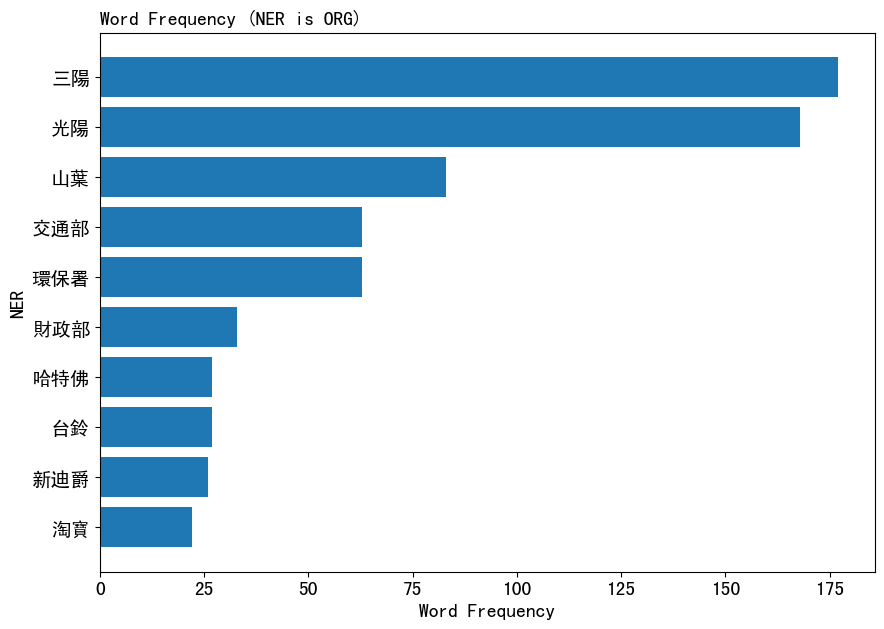

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

C:\Users\collin\AppData\Local\Temp\ipykernel_3032\1258504230.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


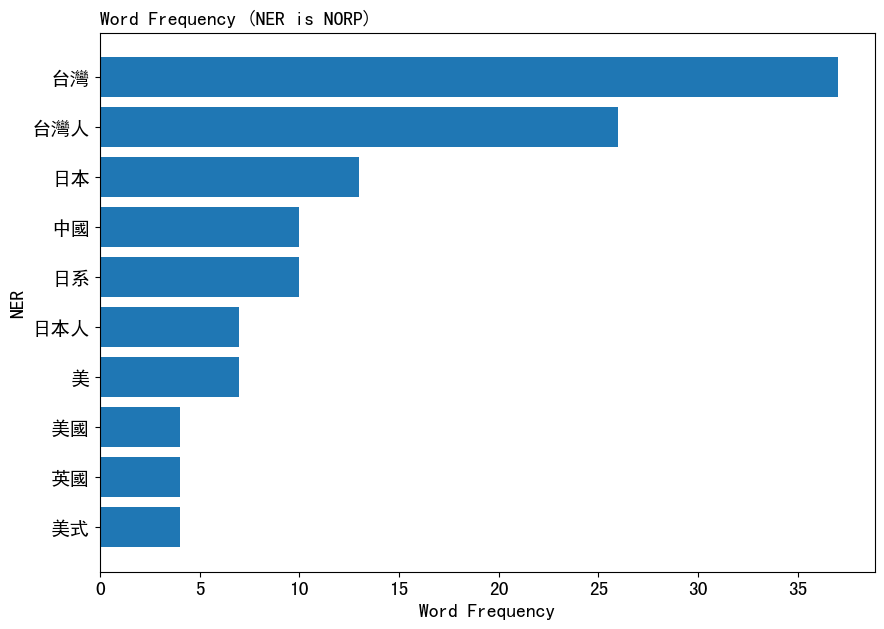

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [ ]:
keyword_list = ['gogoro']
thailand_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{thailand_selected.shape[0]}篇相關貼文")
thailand_selected.head(3)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

### 4.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [ ]:
pos_table['pos'].unique()

array(['Nh', 'VH', 'COMMACATEGORY', 'SHI', 'D', 'Dk', 'Nd', 'VA', 'Di',
       'P', 'DE', 'Na', 'V_2', 'VC', 'Da', 'VG', 'Nb', 'Cbb', 'Nes', 'Nc',
       'Nep', 'VE', 'VJ', 'Neu', 'Nf', 'VD', 'T', 'VB', 'Dfa', 'VK', 'Nv',
       'VCL', 'Ncd', 'FW', 'Neqa', 'A', 'Ng', 'VL', 'VHC', 'Caa', 'VAC',
       'VF', 'Dfb', 'Cab', 'VI', 'Neqb', 'I', 'Cba', 'PERIODCATEGORY',
       'DM', 'PARENTHESISCATEGORY', 'DASHCATEGORY', 'COLONCATEGORY',
       'SPCHANGECATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [ ]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
16,Na,65200
5,D,39841
37,VC,29574
43,VH,21964
7,DE,14096
30,P,10754
40,VE,8604
26,Nf,8577
4,Cbb,8527
18,Nc,8181


C:\Users\collin\AppData\Local\Temp\ipykernel_13764\2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


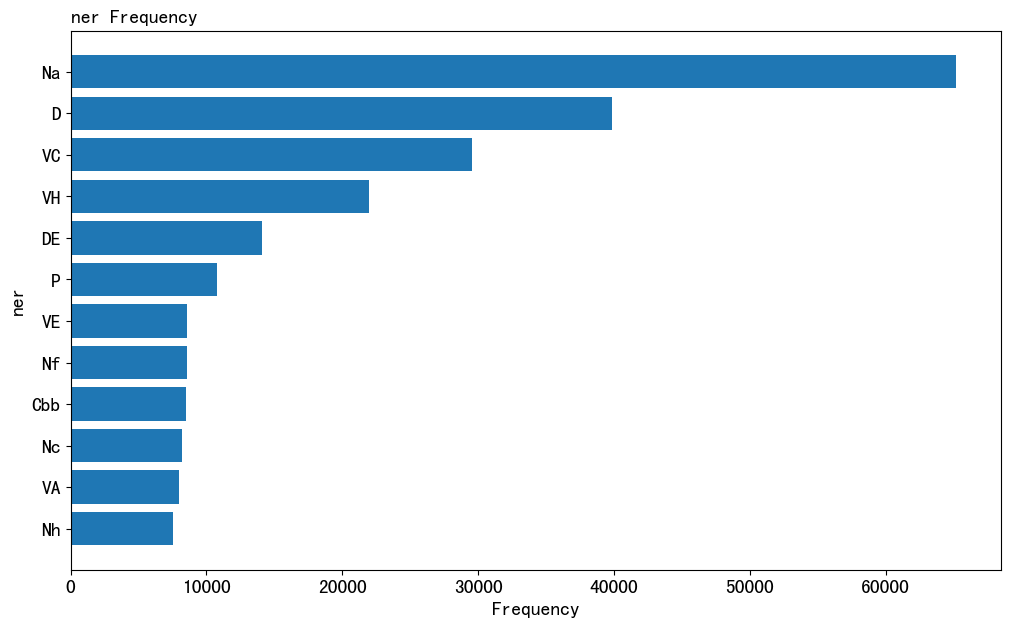

In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)
+ 我們可以找出談論吃到飽時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [ ]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
70,光陽,412
8,三陽,180
634,迪爵,143
223,宏佳騰,96
94,勁戰,93
475,火星,86
125,台鈴,74
260,山葉,62
501,睿能,60
343,新迪爵,57


C:\Users\collin\AppData\Local\Temp\ipykernel_13764\502700507.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


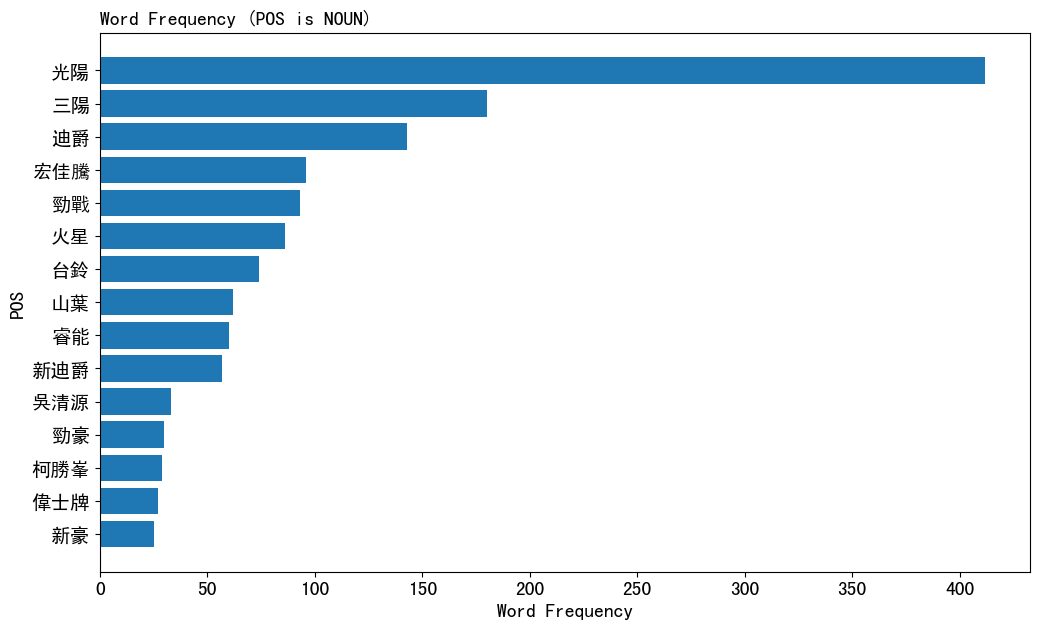

In [ ]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的動詞(VERB)
+ 我們可以找出談論吃到飽時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [ ]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
118,保養,798
98,使用,514
1271,推薦,337
2976,騎乘,313
2142,維修,291
2325,補充,275
1690,比較,261
1999,看過,259
1943,發動,246
1623,服務,239


C:\Users\collin\AppData\Local\Temp\ipykernel_13764\1955970811.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


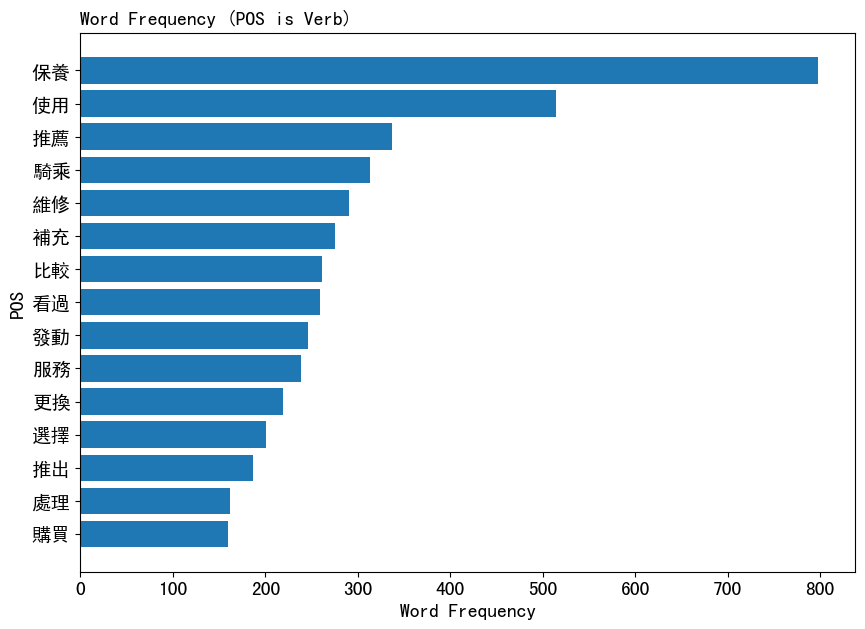

In [ ]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is Verb)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

## 5. 利用SnowNLP進行情緒分析

In [ ]:
from snownlp import SnowNLP

In [ ]:
sentence_table = pd.read_csv("rawData/sentence_table_motor.csv") #匯資料

sentiment_date = pd.merge(sentence_table,thailand_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
13,2,現在是電動車的世代了,2020-01-03 03:48:48,ptt
14,2,特斯拉在台灣個月交台,2020-01-03 03:48:48,ptt
15,2,但是台萬,2020-01-03 03:48:48,ptt
16,2,能負擔的人不多,2020-01-03 03:48:48,ptt
17,2,然而台幾萬塊而已就能體驗電動技術,2020-01-03 03:48:48,ptt


In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
13,2,現在是電動車的世代了,2020-01-03 03:48:48,ptt,0.976409
14,2,特斯拉在台灣個月交台,2020-01-03 03:48:48,ptt,0.183450
15,2,但是台萬,2020-01-03 03:48:48,ptt,0.480148
16,2,能負擔的人不多,2020-01-03 03:48:48,ptt,0.361921
17,2,然而台幾萬塊而已就能體驗電動技術,2020-01-03 03:48:48,ptt,0.371440


In [ ]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.998000e+03
mean     3.511579e-01
std      3.120316e-01
min      2.941383e-08
25%      5.597284e-02
50%      2.584960e-01
75%      5.755809e-01
max      9.999959e-01
Name: sentimentValue, dtype: float64

<Axes: >

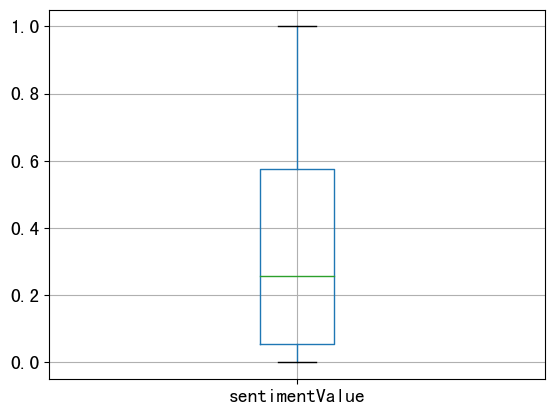

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [ ]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

,artDate,sentimentValue
0,2020-01,0.271667
1,2020-02,0.350560
2,2020-03,0.299933
3,2020-04,0.398194
4,2020-05,0.536687


C:\Users\collin\AppData\Local\Temp\ipykernel_13764\2520951907.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


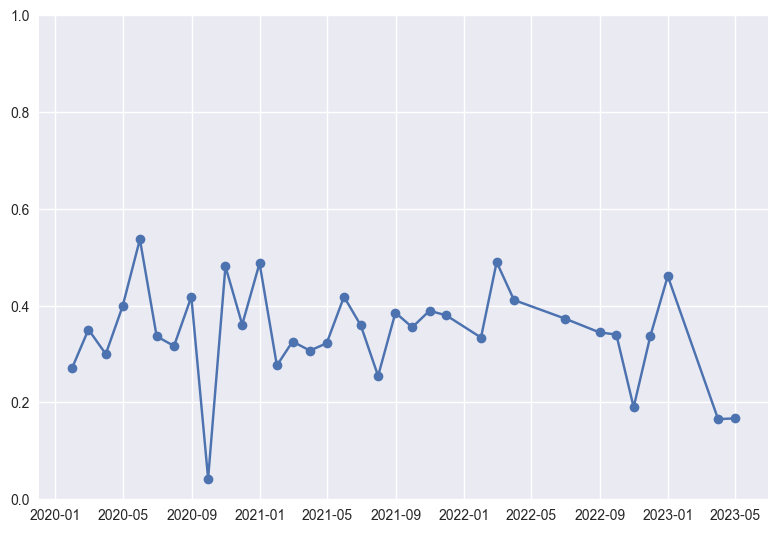

In [ ]:
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

### 詞彙探索
從上圖中可以發現 2020年6月的情緒分數相對高，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [ ]:
filter_sentiment = sent_date[sent_date['artDate']=='2020-06']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.9]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
4822,219,在能確保核心技術,2020-06,ptt,0.968127
4824,219,吳清源說，用中油的共用電池系統發展電動機車，有國營事業資源技術全台加油站通,2020-06,ptt,0.931611
4830,219,從開始發展這幾年，兩陽被酸了好幾年，其中三陽的吳清源直被酸只會講幹話，,2020-06,ptt,0.924278
5434,253,若本身是二代的車友且會發生斷電的情形，在未發生車輛事故，但影響使用的狀況是否仍,2020-06,ptt,0.997041
5455,253,若有相關經驗的版友，在檢修作業的過程中，應該要做什麼或注意哪些事情，可以保障,2020-06,ptt,0.982044


In [ ]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,219,0.968127,///
1,219,0.968127,三陽
2,219,0.968127,下
3,219,0.968127,半
4,219,0.968127,年


In [ ]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [ ]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

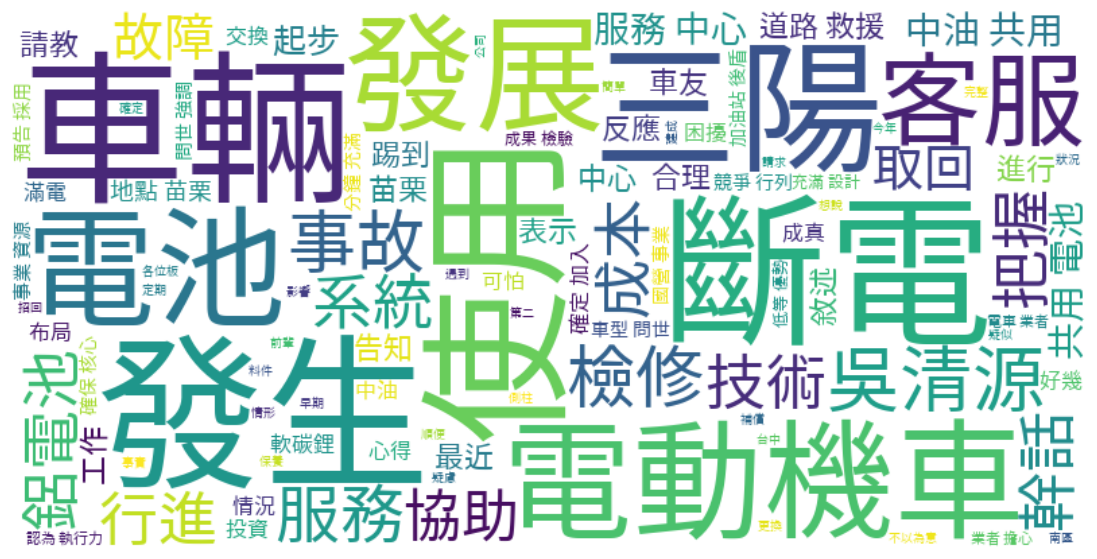

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(("謝謝", "一下", "問題", "感覺", "目前", "請問", "發現", "直接", "知道", "看到", "現在", "車子", "建議", "車主", "希望", "10", "一點"))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

#### 看 Gogoro 的討論趨勢